In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

import pandas as pd

# Import data & initial guess

In [2]:
def create_filepaths(numbers, pre_path):
    padded_numbers = []
    file_ext = '.dat'
    for n in numbers:
        if n <= 9:
            padded_numbers = np.append(padded_numbers, pre_path + '00' + str(n) + file_ext)
        elif n <= 99:
            padded_numbers = np.append(padded_numbers, pre_path + '0' + str(n) + file_ext)
        else:
            padded_numbers = np.append(padded_numbers, pre_path + str(n) + file_ext)
    return padded_numbers

In [3]:
def decayingSinModel(time, freq, T_decay, amp, phase, offset, drift):
    # Linearly decaying sinusoidal function
    return amp * np.exp(-time/T_decay) * np.sin(2*np.pi*( freq*time ) + np.radians(phase)) + offset + (drift*time)

In [30]:
def ramsey_fit_guess_default():
    freq_guess = 5.0 # MHz
    T_decay_guess = 1.0 # us
    amp_guess = 0.5
    phase_guess = 180
    offset_guess = 0.5
    drift_guess = 0.0
    return [freq_guess, T_decay_guess, amp_guess, phase_guess, offset_guess, drift_guess]

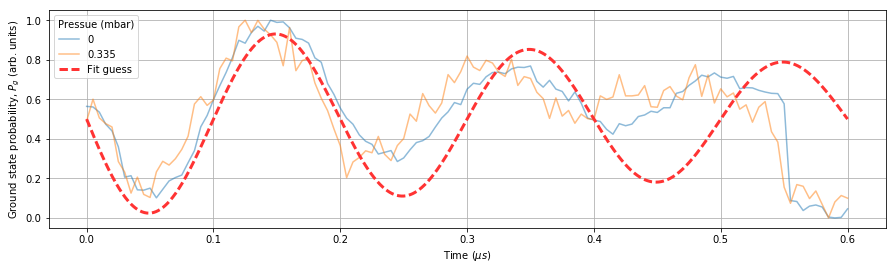

In [31]:
#date = '120417'
#file_numbers = [1, 28]
#pressures = [0, 0.335]
def ramsey_fit_test(date, file_numbers, pressures=[], pressure_errors=[], guess=ramsey_fit_guess_default(), 
                    eval_time=0.0, crop=[0,0], local=False, figSize=(15.0, 4.0), normalise=False):
    if local:
        file_path = "SR" + date + "_"
        full_paths = create_filepaths(file_numbers, file_path)
    else:
        file_path = "C:\data\\" + date + "\\SR" + date + "_"
        full_paths = create_filepaths(file_numbers, file_path)
        
    if pressures == []: pressures = np.arange(1, len(full_paths)+1, 1)

    matplotlib.rcParams['figure.figsize'] = figSize
    min_time, max_time = 0, 0
    for i, path in enumerate(full_paths):
        data = np.loadtxt(path)
        time = data[:,1] * 1E6
        time = time[crop[0]:len(time)-crop[1]]
        p_g = data[:,4] * 1E9
        p_g = p_g[crop[0]:len(p_g)-crop[1]]
        if normalise: 
            p_g = p_g - np.min(p_g)
            p_g = p_g / np.max(p_g)
        
        min_time = np.min([min_time, np.min(time)])
        max_time = np.max([max_time, np.max(time)])
        
        plt.plot(time, p_g, alpha=0.5, label=str(pressures[i]))

    timeSteps = np.linspace(min_time, max_time, 1000)

    plt.plot(timeSteps, decayingSinModel(timeSteps, *guess), '--', lw=3, color=[1.0,0.2,0.2], label='Fit guess')
    plt.xlabel('Time ($\mu s$)')
    plt.ylabel('Ground state probability, $P_g$ (arb. units)')
    plt.grid()
    plt.legend(title='Pressue (mbar)')

#ramsey_fit_test(date, file_numbers, pressures, local=True, normalise=True)

# Fit sinusoidal waveforms

,Pressure,Pressure error,Frequency,Frequency error,T decay,T decay error,Amplitude,Amplitude error,Initial phase,Initial phase error,Offset,Offset error,Drift,Drift error,Phase shift /t,Phase shift /t error
0,0.000,0.0,5.222938,0.019575,0.295945,0.012772,0.690885,0.016706,168.767851,1.096319,0.605343,0.008237,-0.249005,0.034203,0.000000,9.965794
1,0.335,0.0,5.584217,0.049234,0.319546,0.034829,0.597554,0.034998,171.144038,2.770217,0.576714,0.018130,-0.097398,0.076910,130.060409,19.073642


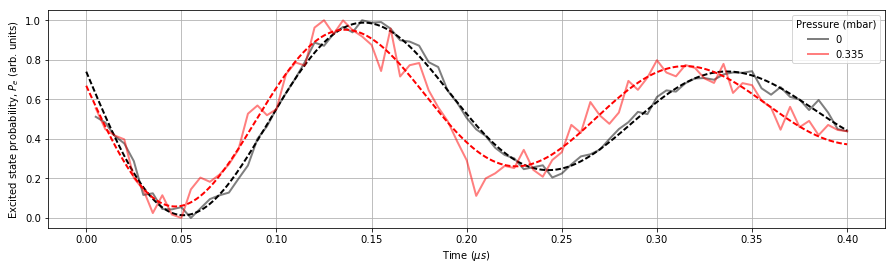

In [32]:
def ramsey_fit(date, file_numbers, pressures=[], pressure_errors=[], guess=ramsey_fit_guess_default(),
               eval_time=0.0, crop=[0,0], local=False, figSize=(15.0, 4.0), normalise=False):
    if local:
        file_path = "SR" + date + "_"
        full_paths = create_filepaths(file_numbers, file_path)
    else:
        file_path = "C:\data\\" + date + "\\SR" + date + "_"
        full_paths = create_filepaths(file_numbers, file_path)
    
    matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)
    colors = ['k','r','g','b','c','m','y']
    params = ['Frequency', 'T decay', 'Amplitude', 'Initial phase', 'Offset', 'Drift']
    if pressures == []: pressures = np.arange(1, len(full_paths)+1, 1)
    if pressure_errors == []: pressure_errors = np.zeros(len(full_paths))
        
    popts = []
    perrs = []
    df = pd.DataFrame(columns=['Pressure', 'Pressure error', *params, *[p + ' error' for p in params]])
    min_time, max_time = 0, 0
    for i, path in enumerate(full_paths):
        data = np.loadtxt(path)
        time = data[:,1] * 1E6
        time = time[crop[0]:len(time)-crop[1]]
        p_g = data[:,4] * 1E9
        p_g = p_g[crop[0]:len(p_g)-crop[1]]
        if normalise: 
            p_g = p_g - np.min(p_g)
            p_g = p_g / np.max(p_g)
        
        min_time = np.min([min_time, np.min(time)])
        max_time = np.max([max_time, np.max(time)])

        popt,pcov = curve_fit(decayingSinModel, time, p_g, p0=guess)
        perr = np.sqrt(np.diag(pcov))
        popts = np.concatenate((popts, popt), axis=0)
        perrs = np.concatenate((perrs, perr), axis=0)

        df.loc[i] = [pressures[i], pressure_errors[i], *popt, *perr]
        matplotlib.rcParams['figure.figsize'] = figSize

        timeSteps = np.linspace(min_time, max_time, 1000)
        p_g_fit = decayingSinModel(timeSteps, *popt)
        plt.plot(time, p_g, '-', lw=2, color=colors[np.mod(i, len(colors))], alpha=0.5, label=str(pressures[i]))
        plt.plot(timeSteps, p_g_fit, '--', lw=2, color=colors[np.mod(i, len(colors))], alpha=1.0)

    plt.xlabel('Time ($\mu s$)')
    plt.ylabel('Excited state probability, $P_e$ (arb. units)')
    plt.grid()
    plt.legend(title='Pressure (mbar)')

    popts = np.reshape(popts, [len(file_numbers), len(params)])
    perrs = np.reshape(perrs, [len(file_numbers), len(params)])
    ref_popt = popts[0]
    diff_freq = popts[:,0] - ref_popt[0]
    diff_init_phase = popts[:,3] - ref_popt[3]
    if eval_time != 0.0: diff_eval_phase = (360 * diff_freq * eval_time) + diff_init_phase # MHz * us
    diff_phase = (360 * diff_freq)

    if eval_time != 0.0: plt.axvline(x=eval_time, color='r', linestyle='--')

    df['Phase shift /t'] = diff_phase
    ref_error = df['Frequency error'][0]
    df['Phase shift /t error'] = ((df['Frequency error']**2 + ref_error**2)**0.5)*360
    if eval_time != 0.0: df['Phase shift at T'] = diff_eval_phase
    columns = ['Pressure', 'Pressure error', *list(np.array([[p, p + ' error'] for p in params]).flatten()), 'Phase shift /t', 'Phase shift /t error']
    if eval_time != 0.0: columns = [*columns, 'Phase shift at T']
    return df[columns]
    
#df = ramsey_fit(date, file_numbers, pressures, crop=[1,40], local=True, normalise=True)
#df